In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings


from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import(
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Input
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [12]:
#Data

covtype = fetch_covtype()
X, y = covtype.data, covtype.target

#Exploration

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nClass distribution:")
unique, counts = np.unique(y, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"  Class {cls}: {cnt:,} ({cnt/len(y)*100:.2f}%)")
print(covtype.feature_names)

X shape: (581012, 54)
y shape: (581012,)

Class distribution:
  Class 1: 211,840 (36.46%)
  Class 2: 283,301 (48.76%)
  Class 3: 35,754 (6.15%)
  Class 4: 2,747 (0.47%)
  Class 5: 9,493 (1.63%)
  Class 6: 17,367 (2.99%)
  Class 7: 20,510 (3.53%)
['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3', 'Soil_Type_0', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soi

In [13]:
# sklearn uses classes 1-7, convert to 0-6 for TensorFlow
y = y - 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale only the 10 numerical features, leave the binary columns (soil/wilderness) as-is
numerical_cols = list(range(10))

scaler = StandardScaler()
X_train[:, numerical_cols] = scaler.fit_transform(X_train[:, numerical_cols])
X_test[:, numerical_cols]  = scaler.transform(X_test[:, numerical_cols])

# Class weights — inverse frequency for 7 classes
total = len(y_train)
class_weight = {}
for cls in range(7):
    cnt = (y_train == cls).sum()
    class_weight[cls] = total / (7 * cnt)
    print(f"Class {cls+1}: {cnt:,} samples | weight: {class_weight[cls]:.4f}")

Class 1: 169,472 samples | weight: 0.3918
Class 2: 226,640 samples | weight: 0.2930
Class 3: 28,603 samples | weight: 2.3215
Class 4: 2,198 samples | weight: 30.2099
Class 5: 7,594 samples | weight: 8.7439
Class 6: 13,894 samples | weight: 4.7791
Class 7: 16,408 samples | weight: 4.0469


In [14]:
inp_dim = X_train.shape[1]

model = Sequential([
    Input(shape=(inp_dim,)),
    Dense(256),
    LeakyReLU(negative_slope=0.01),
    Dropout(0.3),
    Dense(128),
    LeakyReLU(negative_slope=0.01),
    Dropout(0.3),
    Dense(64),
    LeakyReLU(negative_slope=0.01),
    Dropout(0.3),
    Dense(7, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 256)            │        14,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,687 (217.53 KB)

 Trainable params: 55,687 (217.53 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=512,
    class_weight=class_weight,
    callbacks=[es],
    verbose=1
)

Epoch 1/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.4763 - loss: 0.9969 - val_accuracy: 0.6039 - val_loss: 0.8608
Epoch 2/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.6027 - loss: 0.6407 - val_accuracy: 0.6347 - val_loss: 0.8023
Epoch 3/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.6315 - loss: 0.5824 - val_accuracy: 0.6679 - val_loss: 0.7331
Epoch 4/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.6526 - loss: 0.5452 - val_accuracy: 0.6785 - val_loss: 0.7088
Epoch 5/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.6641 - loss: 0.5183 - val_accuracy: 0.7009 - val_loss: 0.6625
Epoch 6/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.6782 - loss: 0.4953 - val_accuracy: 0.7082 - val_loss: 0.6429
Epoch 7/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.6887 - loss: 0.4747 - val_accuracy: 0.7214 - val_loss: 0.6290
Epoch 8/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6925 - loss: 0.4610 - va

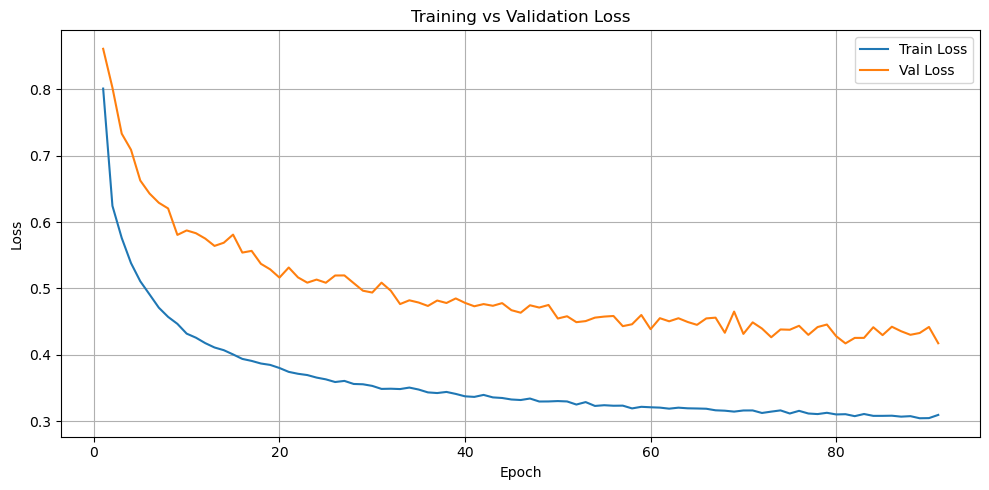

In [16]:
epochs_run = len(history.history['loss'])

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(range(1, epochs_run + 1), history.history['loss'], label='Train Loss')
ax.plot(range(1, epochs_run + 1), history.history['val_loss'], label='Val Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training vs Validation Loss')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

3632/3632 ━━━━━━━━━━━━━━━━━━━━ 3s 854us/step


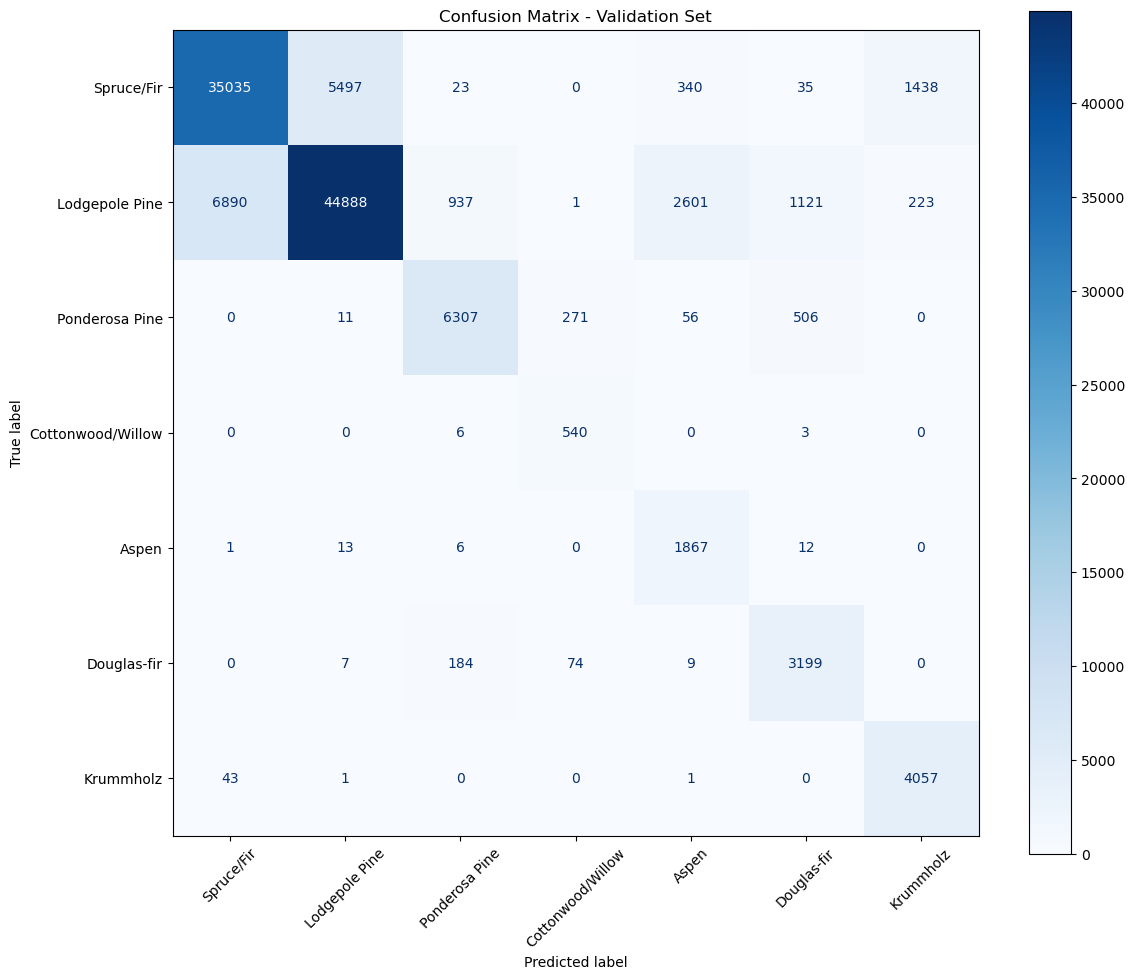

                   precision    recall  f1-score   support

       Spruce/Fir       0.83      0.83      0.83     42368
   Lodgepole Pine       0.89      0.79      0.84     56661
   Ponderosa Pine       0.85      0.88      0.86      7151
Cottonwood/Willow       0.61      0.98      0.75       549
            Aspen       0.38      0.98      0.55      1899
      Douglas-fir       0.66      0.92      0.77      3473
        Krummholz       0.71      0.99      0.83      4102

         accuracy                           0.83    116203
        macro avg       0.70      0.91      0.78    116203
     weighted avg       0.84      0.83      0.83    116203



In [17]:
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = y_test

labels = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 
          'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(12, 10))
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)
plt.title('Confusion Matrix - Validation Set')
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred, target_names=labels))

In [18]:
# Naive model — no class weights, everything else identical
model_naive = Sequential([
    Input(shape=(inp_dim,)),
    Dense(256),
    LeakyReLU(negative_slope=0.01),
    Dropout(0.3),
    Dense(128),
    LeakyReLU(negative_slope=0.01),
    Dropout(0.3),
    Dense(64),
    LeakyReLU(negative_slope=0.01),
    Dropout(0.3),
    Dense(7, activation='softmax')
])

model_naive.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

es_naive = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_naive = model_naive.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=512,
    callbacks=[es_naive],
    verbose=1
)

Epoch 1/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.6647 - loss: 0.8329 - val_accuracy: 0.7680 - val_loss: 0.5316
Epoch 2/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.7605 - loss: 0.5605 - val_accuracy: 0.7971 - val_loss: 0.4680
Epoch 3/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7818 - loss: 0.5121 - val_accuracy: 0.8177 - val_loss: 0.4321
Epoch 4/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.7977 - loss: 0.4795 - val_accuracy: 0.8335 - val_loss: 0.4040
Epoch 5/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8073 - loss: 0.4580 - val_accuracy: 0.8414 - val_loss: 0.3863
Epoch 6/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8136 - loss: 0.4447 - val_accuracy: 0.8472 - val_loss: 0.3686
Epoch 7/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8187 - loss: 0.4307 - val_accuracy: 0.8520 - val_loss: 0.3557
Epoch 8/100
908/908 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8221 - loss: 0.42

3632/3632 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


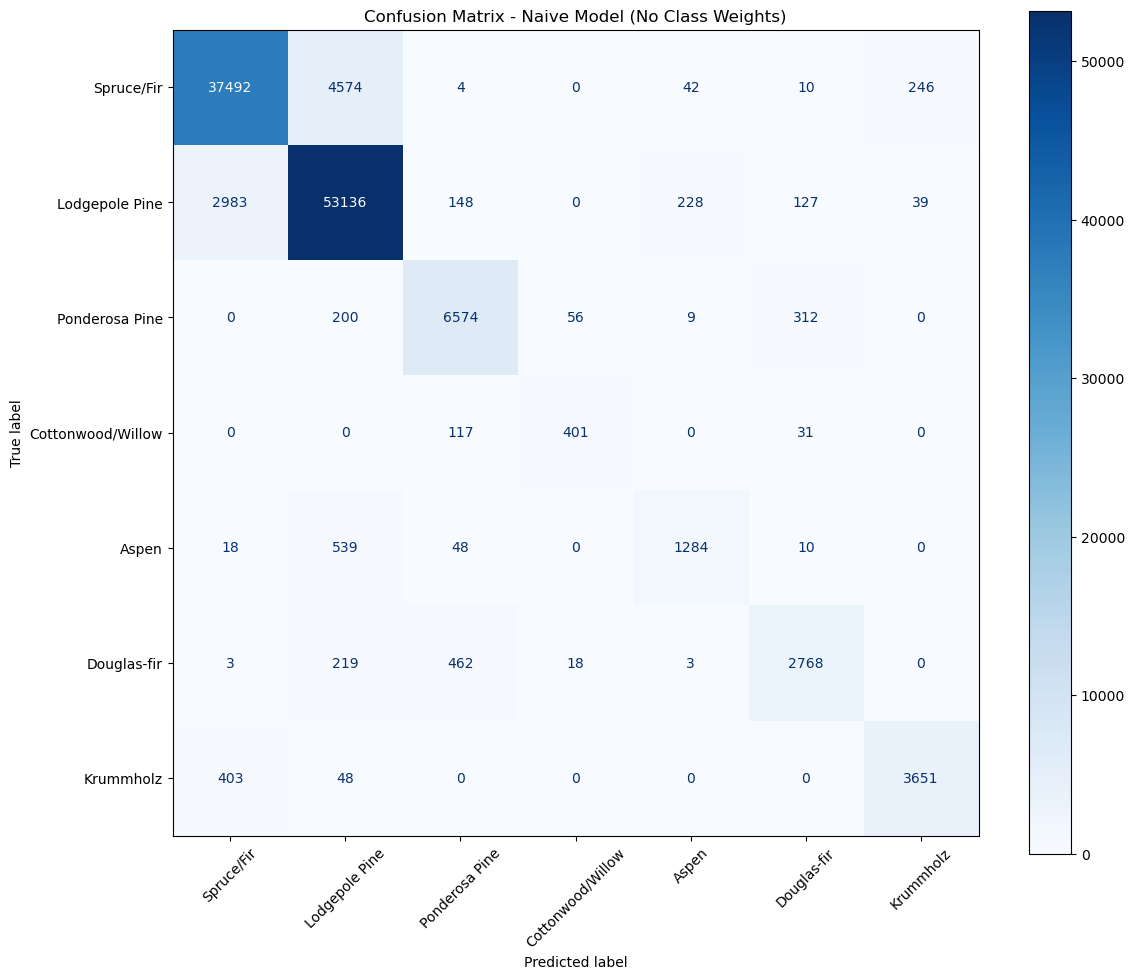

                   precision    recall  f1-score   support

       Spruce/Fir       0.92      0.88      0.90     42368
   Lodgepole Pine       0.90      0.94      0.92     56661
   Ponderosa Pine       0.89      0.92      0.91      7151
Cottonwood/Willow       0.84      0.73      0.78       549
            Aspen       0.82      0.68      0.74      1899
      Douglas-fir       0.85      0.80      0.82      3473
        Krummholz       0.93      0.89      0.91      4102

         accuracy                           0.91    116203
        macro avg       0.88      0.83      0.85    116203
     weighted avg       0.91      0.91      0.91    116203



In [19]:
y_pred_naive = np.argmax(model_naive.predict(X_test), axis=1)

cm_naive = confusion_matrix(y_test, y_pred_naive)
disp_naive = ConfusionMatrixDisplay(confusion_matrix=cm_naive, display_labels=labels)

fig, ax = plt.subplots(figsize=(12, 10))
disp_naive.plot(cmap='Blues', ax=ax, xticks_rotation=45)
plt.title('Confusion Matrix - Naive Model (No Class Weights)')
plt.tight_layout()
plt.show()

print(classification_report(y_test, y_pred_naive, target_names=labels))